In [40]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn.modules.loss import MSELoss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
import tqdm

# create dataset
def sample_X_and_score(gmm, trainN=10000, testN=2000):
  X_train,_,_ = gmm.sample(trainN)
  y_train = gmm.score(X_train)
  X_test,_,_ = gmm.sample(testN)
  y_test = gmm.score(X_test)
  X_train_tsr = torch.tensor(X_train).float()
  y_train_tsr = torch.tensor(y_train).float()
  X_test_tsr = torch.tensor(X_test).float()
  y_test_tsr = torch.tensor(y_test).float()
  return X_train_tsr, y_train_tsr, X_test_tsr, y_test_tsr

def sample_X_and_score_t_depend(gmm, trainN=10000, testN=2000, sigma=5, partition=20, EPS=0.02):
  """Uniformly partition [0,1] and sample t from it, and then
  sample x~ p_t(x) and compute \nabla \log p_t(x)
  finally return the dataset x, score, t (train and test)
  """
  trainN_part, testN_part = trainN //partition, testN //partition
  X_train_list, y_train_list, X_test_list, y_test_list, T_train_list, T_test_list = [], [], [], [], [], []
  for t in np.linspace(EPS, 1.0, partition):
    gmm_dif = diffuse_gmm(gmm, t, sigma)
    X_train_tsr, y_train_tsr, X_test_tsr, y_test_tsr = \
      sample_X_and_score(gmm_dif, trainN=trainN_part, testN=testN_part, )
    T_train_tsr, T_test_tsr = t * torch.ones(trainN_part), t * torch.ones(testN_part)
    X_train_list.append(X_train_tsr)
    y_train_list.append(y_train_tsr)
    X_test_list.append(X_test_tsr)
    y_test_list.append(y_test_tsr)
    T_train_list.append(T_train_tsr)
    T_test_list.append(T_test_tsr)
  X_train_tsr = torch.cat(X_train_list, dim=0)
  y_train_tsr = torch.cat(y_train_list, dim=0)
  X_test_tsr = torch.cat(X_test_list, dim=0)
  y_test_tsr = torch.cat(y_test_list, dim=0)
  T_train_tsr = torch.cat(T_train_list, dim=0)
  T_test_tsr = torch.cat(T_test_list, dim=0)
  return X_train_tsr, y_train_tsr, T_train_tsr, X_test_tsr, y_test_tsr, T_test_tsr

# visualization
def kdeplot(pnts, label="", ax=None, titlestr=None, **kwargs):
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(x=pnts[:,0], y=pnts[:,1], ax=ax, label=label, **kwargs)
  if titlestr is not None:
    ax.set_title(titlestr)

def visualize_diffusion_distr(x_traj_rev, leftT=0, rightT=-1, explabel=""):
  if rightT == -1:
    rightT = x_traj_rev.shape[2]-1
  figh, axs = plt.subplots(1,2,figsize=[12,6])
  sns.kdeplot(x=x_traj_rev[:,0,leftT], y=x_traj_rev[:,1,leftT], ax=axs[0])
  axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
  plt.axis("equal")
  sns.kdeplot(x=x_traj_rev[:,0,rightT], y=x_traj_rev[:,1,rightT], ax=axs[1])
  axs[1].set_title(f"Density of $x_0$ samples after {rightT} step reverse diffusion")
  plt.axis("equal")
  plt.suptitle(explabel)
  return figh

# functions to diffuse and reverse
def marginal_prob_std(t, sigma):
  return torch.sqrt( (sigma**(2*t) - 1) / 2 / torch.log(torch.tensor(sigma)) )

def marginal_prob_std_np(t, sigma):
  return np.sqrt( (sigma**(2*t) - 1) / 2 / np.log(sigma) )

def diffuse_gmm(gmm, t, sigma):
  beta_t = marginal_prob_std_np(t, sigma)**2 # variance
  noise_cov = np.eye(gmm.dim) * beta_t
  covs_dif = [cov + noise_cov for cov in gmm.covs]
  return GaussianMixture(gmm.mus, covs_dif, gmm.weights)

def reverse_diffusion_time_dep(score_model_td, sampN=500, sigma=5, nsteps=200, ndim=2, exact=False):
  betaT = (sigma**2 - 1) / (2 * np.log(sigma))
  xT = np.sqrt(betaT) * np.random.randn(sampN, ndim)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:,:,0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    t = 1 - i * dt
    tvec = torch.ones((sampN)) * t
    eps_z = np.random.randn(*xT.shape)
    if exact:
      gmm_t = diffuse_gmm(score_model_td, t, sigma)
      score_xt = gmm_t.score(x_traj_rev[:,:,i-1])
    else:
      with torch.no_grad():
        # score_xt = score_model_td(torch.cat((torch.tensor(x_traj_rev[:,:,i-1]).float(),tvec),dim=1)).numpy()
        score_xt = score_model_td(torch.tensor(x_traj_rev[:,:,i-1]).float(), tvec).numpy()
    x_traj_rev[:,:,i] = x_traj_rev[:,:,i-1] + eps_z * (sigma ** t) * np.sqrt(dt) + score_xt * dt * sigma**(2*t)
  return x_traj_rev

# Define GaussianMixture class
class GaussianMixture:
  def __init__(self, mus, covs, weights):
    """
    mus: a list of K 1d np arrays (D,)
    covs: a list of K 2d np arrays (D, D)
    weights: a list or array of K unnormalized non-negative weights, signifying the possibility of sampling from each branch.
      They will be normalized to sum to 1. If they sum to zero, it will err.
    """
    self.n_component = len(mus)
    self.mus = mus
    self.covs = covs
    self.precs = [np.linalg.inv(cov) for cov in covs]
    self.weights = np.array(weights)
    self.norm_weights = self.weights / self.weights.sum()
    self.RVs = []
    for i in range(len(mus)):
      self.RVs.append(multivariate_normal(mus[i], covs[i]))
    self.dim = len(mus[0])

  def score(self, x):
    """
    Compute the score $\nabla_x \log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    scores = np.zeros_like(x)
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      scores += participance[:, i:i+1] * gradvec

    return scores

  def sample(self, N):
    """ Draw N samples from Gaussian mixture
    Procedure:
      Draw N samples from each Gaussian
      Draw N indices, according to the weights.
      Choose sample between the branches according to the indices.
    """
    rand_component = np.random.choice(self.n_component, size=N, p=self.norm_weights)
    all_samples = np.array([rv.rvs(N) for rv in self.RVs])
    gmm_samps = all_samples[rand_component, np.arange(N),:]
    return gmm_samps, rand_component, all_samples

# ScoreModel related
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    self.W = nn.Parameter(torch.randn(embed_dim//2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class ScoreModel_Time(nn.Module):
  """a time-dependent score-based model"""
  def __init__(self, sigma, ):
    super().__init__()
    self.embed = GaussianFourierProjection(10, scale=1) # t:1 ---> 1x10 vector
    self.net = nn.Sequential(nn.Linear(12, 50),
               nn.Tanh(),
               nn.Linear(50,50),
               nn.Tanh(),
               nn.Linear(50,2)) # 2-> scores of 2 dim
    self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma) # noise_schedule -> sigma^t
      
  def forward(self, x, t): # bs x:(1, 2) t:(1)
      t_embed = self.embed(t)
      pred = self.net(torch.cat((x, t_embed), dim=1)) # channel concat
      pred = pred / self.marginal_prob_std_f(t)[:, None]
      return pred


def loss_fn(model, x, marginal_prob_std_f, eps=1e-5): # <==== update
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability, sample t uniformly from [eps, 1.0]
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std_f(random_t,)
  perturbed_x = x + z * std[:, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=(1)))
  return loss

# main

In [41]:
# mean and covariance of the 1,2 Gaussian
mu1 = np.array([0,1.0])
Cov1 = np.array([[1.0,0.0], [0.0,1.0]])
mu2 = np.array([2.0,-1.0])
Cov2 = np.array([[2.0,0.5], [0.5,1.0]])

gmm = GaussianMixture([mu1,mu2],[Cov1,Cov2],[1.0,1.0])

sigma = 10

X_train_samples, _, _ = gmm.sample(N=5000) # <==== modified code
X_train_samples = torch.tensor(X_train_samples).float()

score_model_td = ScoreModel_Time(sigma=sigma)

# Training loop
score_model_td = ScoreModel_Time(sigma=sigma)
marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)
optim = Adam(score_model_td.parameters(), lr=0.01)
pbar = tqdm.trange(500) # 5k samples for 500 iterations.
for ep in pbar:
  loss = loss_fn(score_model_td, X_train_samples, marginal_prob_std_f, 0.05) # <===  use new loss function
  optim.zero_grad()
  loss.backward()
  optim.step()
  pbar.set_description(f"step {ep} loss {loss.item():.3f}")
  if ep == 0:
    print(f"step {ep} loss {loss.item():.3f}")

step 11 loss 1.147:   2%|█▏                                                             | 9/500 [00:00<00:10, 45.42it/s]

step 0 loss 1.891


step 499 loss 1.004: 100%|████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 67.20it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-4.427478758774716, 7.74357176913782, -6.085255792508954, 5.408703121569285)

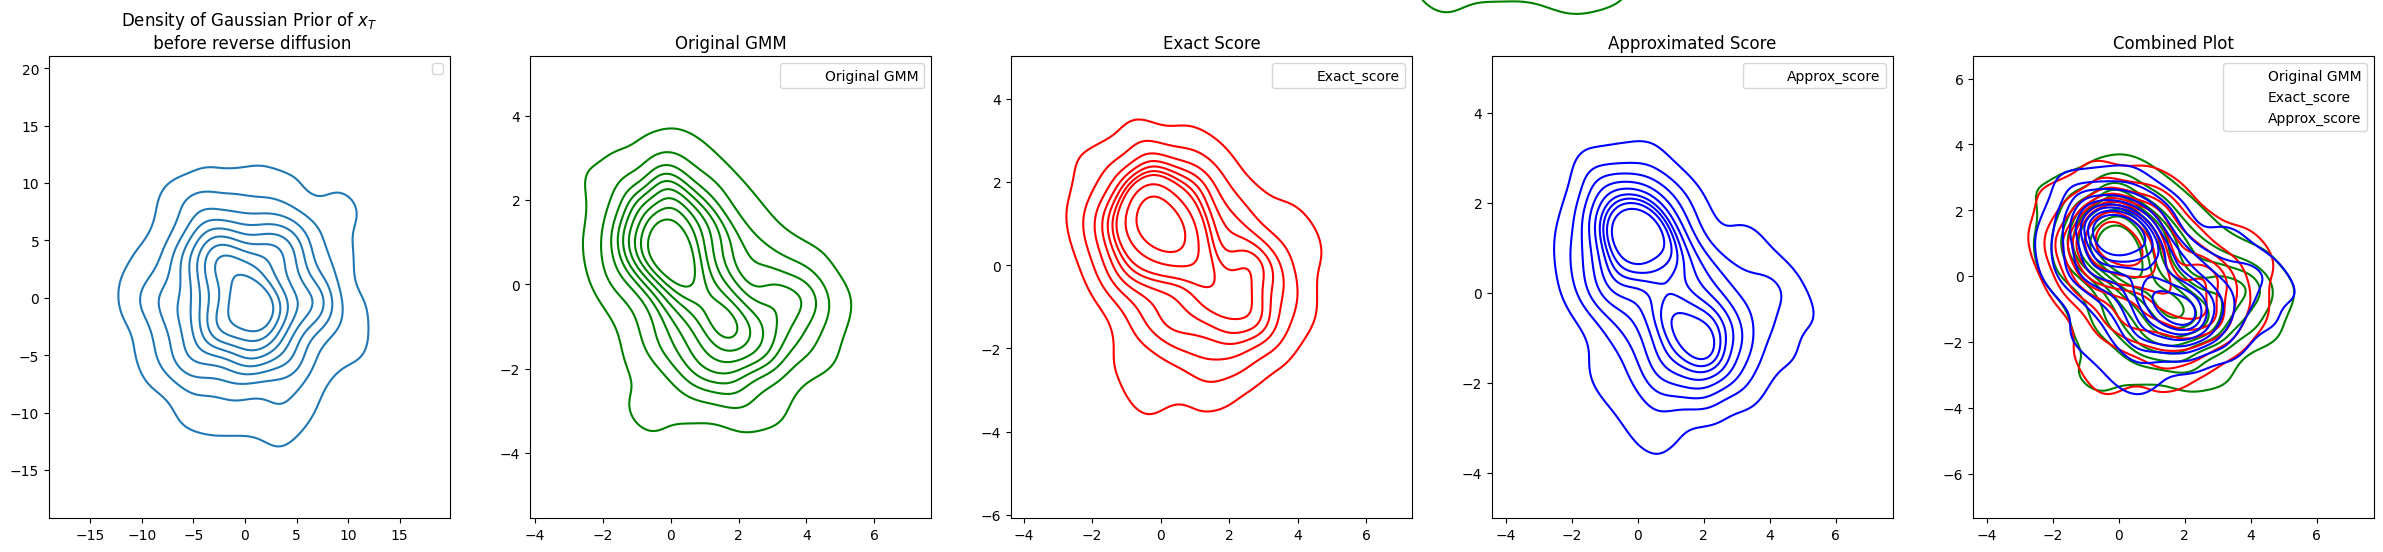

In [42]:
nsteps = 2000
sampN = 1000
x_traj_rev_appr_denois = reverse_diffusion_time_dep(score_model_td, sampN=sampN,
                              sigma=sigma, nsteps=nsteps, ndim=2)

x_traj_rev_exact = reverse_diffusion_time_dep(gmm, sampN=sampN,
                              sigma=5, nsteps=nsteps, ndim=2, exact=True)

# Create 5 subplots
figh, axs = plt.subplots(1, 5, figsize=[30, 6])

# Plot the final distribution before reverse diffusion
kdeplot(x_traj_rev_appr_denois[:,:,0], ax=axs[0])
axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
axs[0].legend()  # Explicitly add legend to this subplot
plt.axis("equal")

# Plot the original GMM samples
original_gmm_samples, _, _ = gmm.sample(sampN)  # Unpack the tuple

# Plot the original GMM samples
kdeplot(original_gmm_samples, ax=axs[1], color='g', label='Original GMM')
axs[1].set_title("Original GMM")
axs[1].legend()  # Explicitly add legend to this subplot
plt.axis("equal")

# Plot the exact score
kdeplot(x_traj_rev_exact[:,:,-1], ax=axs[2], color='r', label='Exact_score')
axs[2].set_title("Exact Score")
axs[2].legend()  # Explicitly add legend to this subplot
plt.axis("equal")

# Plot the approximated score
kdeplot(x_traj_rev_appr_denois[:,:,-1], ax=axs[3], color='b', label='Approx_score')
axs[3].set_title("Approximated Score")
axs[3].legend()  # Explicitly add legend to this subplot
plt.axis("equal")

# Plot all of them on the same subplot
kdeplot(original_gmm_samples, ax=axs[4], color='g', label='Original GMM')
kdeplot(x_traj_rev_exact[:,:,-1], ax=axs[4], color='r', label='Exact_score')
kdeplot(x_traj_rev_appr_denois[:,:,-1], ax=axs[4], color='b', label='Approx_score')
axs[4].set_title("Combined Plot")
axs[4].legend()  # Explicitly add legend to this subplot
plt.axis("equal")



# A runthrough comparison of Reverse Diffusions

In [43]:
def quiver_plot(pnts, vecs, *args, **kwargs):
  plt.quiver(pnts[:, 0], pnts[:,1], vecs[:, 0], vecs[:, 1], *args, **kwargs)

In [44]:
mu1 = np.array([0,1.0])
Cov1 = np.array([[1.0,0.2],
          [0.2,2.0]])
mu2 = np.array([2.0,-3.5])
Cov2 = np.array([[2.0,-1.0],
          [-1.0,2.0]])
mu3 = np.array([-6.5,-5.0])
Cov3 = np.array([[4.0,0.5],
          [0.5,2.0]])
mu4 = np.array([-5.5,5.0])
Cov4 = np.array([[1.0,1.0],
          [1.0,3.0]])
gmm = GaussianMixture([mu1,mu2,mu3,mu4],[Cov1,Cov2,Cov3,Cov4],[1.0,1.0,1.0,1.0])

In [45]:
gmm_samps, _, _ = gmm.sample(5000)
scorevecs = gmm.score(gmm_samps) 

## Ground Truth

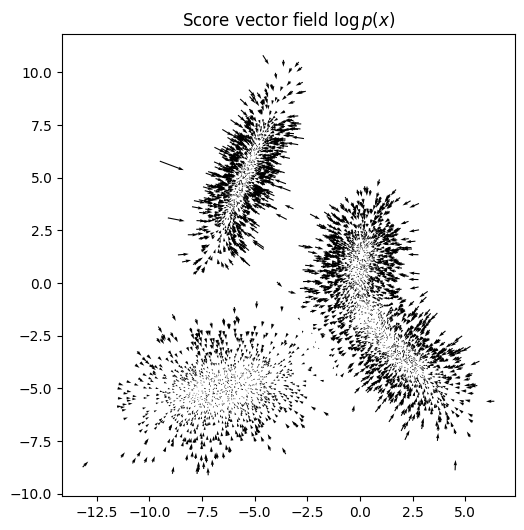

In [46]:
plt.figure(figsize=[6,6])
quiver_plot(gmm_samps, scorevecs)
plt.title("Score vector field $\log p(x)$")
plt.axis("image");

(-15.930544766005914,
 9.145652520476467,
 -12.164941201584188,
 13.859282793136382)

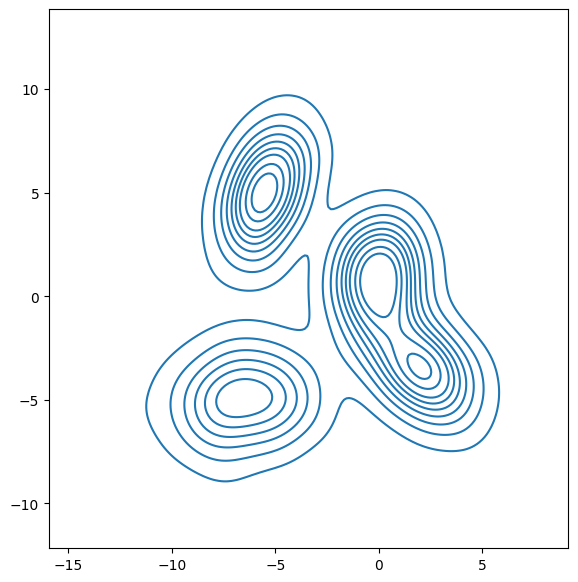

In [47]:
plt.figure(figsize=[7,7])
kdeplot(gmm_samps, label="True distr.")
plt.axis("image")

## Case1: With exact score

In [48]:
x_traj_rev_exact_score = reverse_diffusion_time_dep(gmm, sampN=2000, sigma=25, nsteps=200, ndim=2, exact=True)

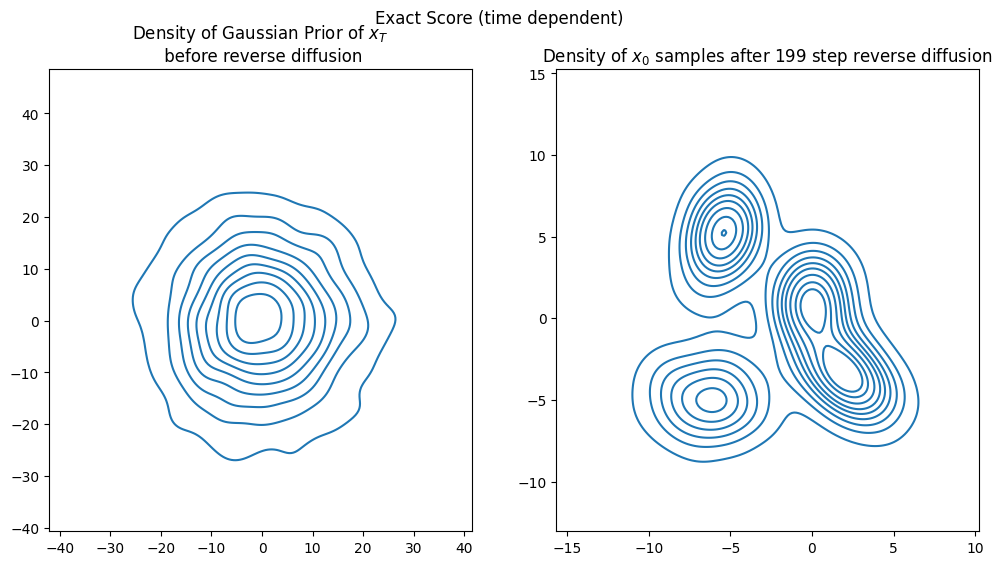

In [49]:
figh = visualize_diffusion_distr(x_traj_rev_exact_score, explabel="Exact Score (time dependent)")

## Case2: With NN-approximated score (Empirical Score Matching method)

In [50]:
sigma = 25
# create data-label pairs(with gt score)
X_train, y_train, T_train, X_test, y_test, T_test = \
  sample_X_and_score_t_depend(gmm, sigma=sigma, trainN=50000, testN=2000, 
                              partition=500, EPS=0.0001)

score_model_esm = ScoreModel_Time(sigma=sigma )

optim = Adam(score_model_esm.parameters(), lr=0.001)
pbar = tqdm.trange(400)
std_vec = marginal_prob_std(T_train, sigma)
for ep in pbar:
  y_pred = score_model_esm(X_train, T_train)
  loss = torch.mean(torch.sum((y_pred - y_train)**2 * std_vec[:, None], dim=(1))) # <===== loss based on ESM
  optim.zero_grad()
  loss.backward()
  optim.step()
  pbar.set_description(f"step {ep} loss {loss.item():.3f}")
  if ep == 0:
    print(f"step {ep} loss {loss.item():.3f}")
  if ep % 25==0:
    y_pred_test = score_model_esm(X_test, T_test)
    loss_test = loss_fun(y_test, y_pred_test)
    print(f"step {ep} test loss {loss.item():.3f}")

step 1 loss 0.338:   0%|▎                                                               | 2/400 [00:00<00:54,  7.24it/s]

step 0 loss 0.378
step 0 test loss 0.378


step 26 loss 0.247:   7%|████▏                                                         | 27/400 [00:02<00:41,  8.99it/s]

step 25 test loss 0.249


step 52 loss 0.198:  13%|████████                                                      | 52/400 [00:05<00:34, 10.23it/s]

step 50 test loss 0.202


step 77 loss 0.160:  20%|████████████                                                  | 78/400 [00:07<00:30, 10.71it/s]

step 75 test loss 0.163


step 101 loss 0.137:  26%|███████████████▎                                            | 102/400 [00:10<00:33,  8.83it/s]

step 100 test loss 0.138


step 127 loss 0.117:  32%|███████████████████                                         | 127/400 [00:13<00:28,  9.71it/s]

step 125 test loss 0.119


step 152 loss 0.100:  38%|██████████████████████▉                                     | 153/400 [00:15<00:22, 10.82it/s]

step 150 test loss 0.102


step 177 loss 0.085:  44%|██████████████████████████▌                                 | 177/400 [00:17<00:21, 10.14it/s]

step 175 test loss 0.086


step 202 loss 0.071:  51%|██████████████████████████████▍                             | 203/400 [00:20<00:19, 10.23it/s]

step 200 test loss 0.072


step 226 loss 0.059:  57%|██████████████████████████████████                          | 227/400 [00:22<00:18,  9.46it/s]

step 225 test loss 0.059


step 251 loss 0.048:  63%|█████████████████████████████████████▊                      | 252/400 [00:25<00:15,  9.82it/s]

step 250 test loss 0.049


step 277 loss 0.040:  70%|█████████████████████████████████████████▋                  | 278/400 [00:28<00:12,  9.62it/s]

step 275 test loss 0.040


step 302 loss 0.033:  76%|█████████████████████████████████████████████▍              | 303/400 [00:30<00:10,  9.69it/s]

step 300 test loss 0.034


step 327 loss 0.029:  82%|█████████████████████████████████████████████████▏          | 328/400 [00:33<00:07, 10.08it/s]

step 325 test loss 0.029


step 352 loss 0.026:  88%|████████████████████████████████████████████████████▉       | 353/400 [00:35<00:04, 10.23it/s]

step 350 test loss 0.026


step 377 loss 0.023:  94%|████████████████████████████████████████████████████████▌   | 377/400 [00:38<00:02, 10.62it/s]

step 375 test loss 0.023


step 399 loss 0.021: 100%|████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.85it/s]


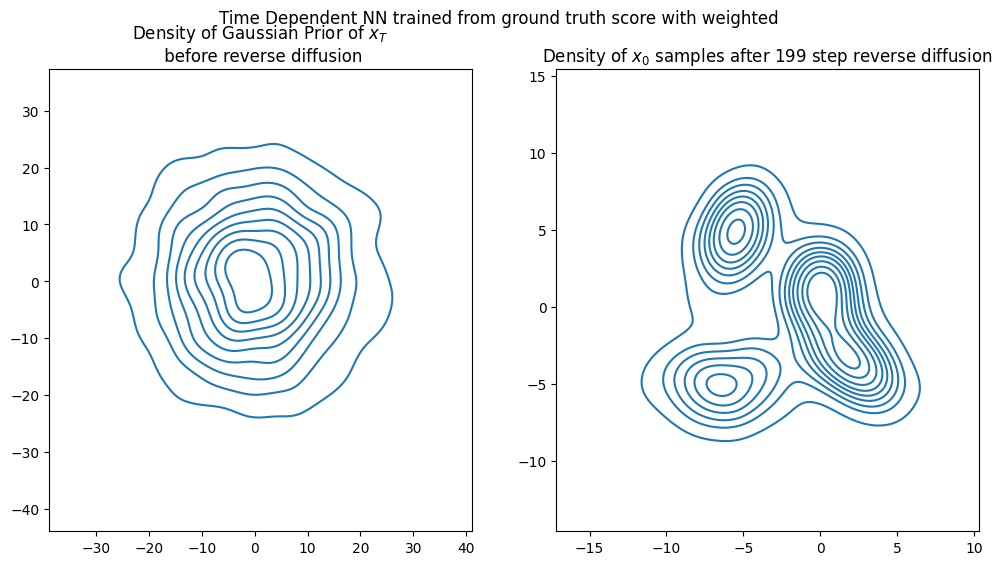

In [51]:
x_traj_esm = reverse_diffusion_time_dep(score_model_esm, sampN=2000, sigma=25, nsteps=200, ndim=2, exact=False)
figh = visualize_diffusion_distr(x_traj_esm, explabel="Time Dependent NN trained from ground truth score with weighted")

## Case3: With NN-approximated score (Denoising Score Matching method)

In [53]:
X_train_tsr, _, _, _ = sample_X_and_score(gmm, trainN=20000)

In [54]:
sigma = 25
score_model_dsm = ScoreModel_Time(sigma=sigma, )
marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)
optim = Adam(score_model_dsm.parameters(), lr=0.005)
pbar = tqdm.trange(400)
for ep in pbar:
  loss = loss_fn(score_model_dsm, X_train_tsr, marginal_prob_std_f, 0.05) # <===== DSM
  optim.zero_grad()
  loss.backward()
  optim.step()
  pbar.set_description(f"step {ep} loss {loss.item():.3f}")
  if ep == 0:
    print(f"step {ep} loss {loss.item():.3f}")

step 3 loss 1.590:   1%|▋                                                               | 4/400 [00:00<00:26, 14.98it/s]

step 0 loss 2.231


step 399 loss 1.152: 100%|████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 25.76it/s]


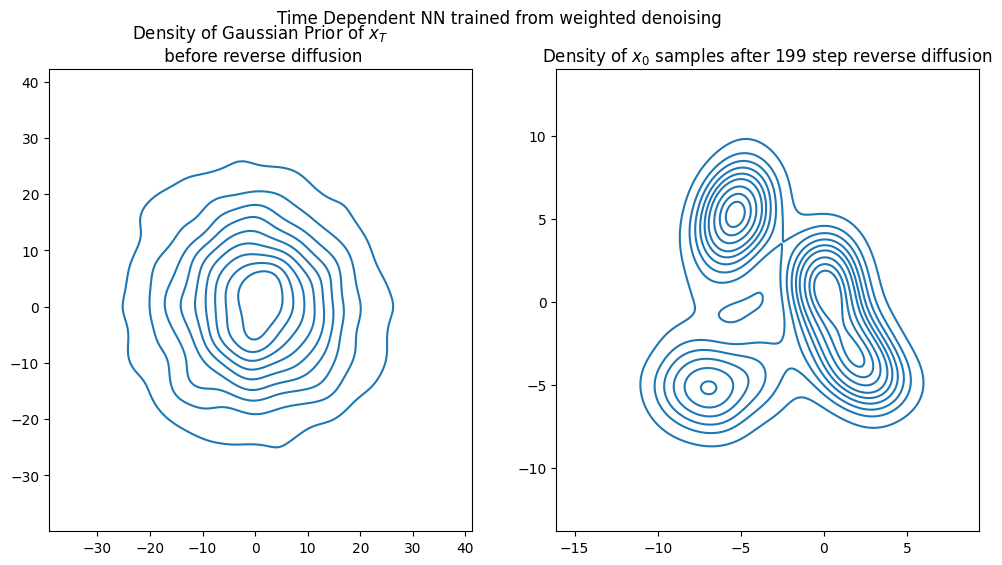

In [55]:
x_traj_dsm = reverse_diffusion_time_dep(score_model_dsm, sampN=2000, sigma=25, nsteps=200, ndim=2, exact=False)
figh = visualize_diffusion_distr(x_traj_dsm, explabel="Time Dependent NN trained from weighted denoising")

# Result Comparison